# Covariance Networks (CovNet)

Here we demonstrate the implementation of the *`covariance networks (CovNet)`* framework developed by __[*Sarkar and Panaretos (2022)*](https://doi.org/10.1111/rssb.12551)__. The relevant functions are within the **`CovNetworks`** and **`Important_Functions`** modules inside `source_codes`

A `CovNet` model can be built using the *`CovNetworks`* module by specifying the parameters <br>
(**Note:** We need to import *`pytorch`* and *`numpy`* before importing the other modules)

In [1]:
import os
import sys
import torch
import numpy as np

sys.path.insert(1, "source_codes")

import CovNetworks as CN

In [2]:
method = "Deepshared"   # Deepshared CovNet
N, d = 100, 2           # sample size and dimension of the domain

model = CN.CovNetDeepShared(d, N, depth=3, R=20, act_fn=torch.nn.Sigmoid())
    # Creats a Deepshared CovNet model with depth=3, R=20, activation=Sigmoid
    # for 100 functional observations on a 2D domain.

There are three different types of `CovNet` models -- `Shallow`, `Deep` and `Deepshared`.
Accordingly, there are three different model classes in *`CovNetworks`* for creating these models.
 - *`CN.CovNetShallow(d,N,R,act_fn,init)`*  ----  *Shallow CovNet* model.
 - *`CN.CovNetDeep(d,N,R,depth,n_nodes,act_fn,init)`*  ----  *Deep CovNet* model.
 - *`CN.CovNetDeepShared(d,N,R,depth,act_fn,init)`*  ----  *Deepshared CovNet* model.

**Parameters:**
> * N ---- number of functional observations.
> * d ---- dimension of the domain. <br>
 **Note:** N & d are usually inferred from the input data.
> * R ---- number of *nodes* of the model.
> * depth ---- *depth* of the model (only for *deep* and *deepshared* variants).
> * n_nodes ---- number of nodes for each of the individual component networks (only for the *deep* variant).
> * act_fn ---- *activation function* for the model (optional, default: *Sigmoid*). <br>
An element from __[torch.nn.NonlinearActivation](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity)__.
> * init ---- *initialization* of the *weights* of the model (optional, default: *Xavier Normal*). <br>
An element from __[torch.nn.init](https://pytorch.org/docs/stable/nn.init.html)__. <br>
 **Note:** The *biases* of the model are initialized as 0.

Once the *model* is created, it can be fitted to the data using *any* available optimization routine from __[torch.optim](https://pytorch.org/docs/stable/optim.html)__. We used __[Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html)__ in our implementations.

In [3]:
u = np.loadtxt(os.path.join("Demo-data","locations.dat"),dtype="float32")
D, d = u.shape # Number of grid points and dimension of the domain
x = np.loadtxt(os.path.join("Demo-data","Example.dat"),dtype="float32")
N = x.shape[0] # Number of functional observations
if x.shape[1] != D:
    sys.exit("Data shape mismatch!! Aborting execution ...")
print('N='+str(N)+', D='+str(D)+', d='+str(d))
    
u = torch.from_numpy(u)
x = torch.from_numpy(x)

N=200, D=2500, d=2


In [4]:
model = CN.CovNetDeepShared(d,N,depth=3,R=20,act_fn=torch.nn.Sigmoid())

In [5]:
optimizer = torch.optim.Adam(model.params,lr=0.01)

def loss_fn(x,x_hat): # loss function to be minimized
    D = x.shape[1]
    l1 = torch.matmul(x,x.T)/D
    l2 = torch.matmul(x_hat,x_hat.T)/D
    l3 = torch.matmul(x,x_hat.T)/D
    l = torch.mean(l1**2) + torch.mean(l2**2) - 2*torch.mean(l3**2) + torch.mean(l1)**2 + torch.mean(l2)**2 - 2*torch.mean(l3)**2
    return l

In [6]:
train_loss = []
for i in range(500):
    loss = loss_fn(x,model(u))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_loss.append(loss.item())

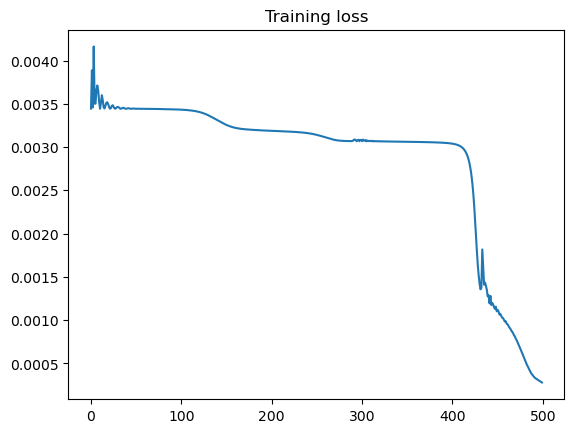

In [7]:
import matplotlib.pyplot as plt
plt.plot(train_loss)
plt.title("Training loss")
plt.show()

A more sophisticated fitting algorithm with *minibatch learning* and *early stopping* was used in our implementations. <br> The function **cnet_optim_best** is within the *`Important_functions`* module 

 - `Ifn.cnet_optim_best(x,u,model,loss_fn,optimizer,split,epochs,burn_in,interval,checkpoint_file)`
 
**Parameters:**
> * x ---- input functional observations. A matrix of size NxD, where D is the number of grid locations.
> * u ---- locations of the functional data. A matrix of size Dxd.
> * model ---- a CovNet model.
> * loss_fn ---- function to compute difference between the observed and the fitted surfaces. <br>
 In our context, the relevant function is **Ifn.loss_COV**.
> * optimizer ---- an optimizer for optimizing the model. <br>
 An element from **torch.optim**, initiated with **model.params**
> * split ---- a splitting mechanism for mini-batch learning. See *`Important_functions`* for details.
> * epochs ---- number of epochs to run the optimizer (optional, default: 1000).
> * burn_in ---- number of epochs before initiating *early stopping* (optional, default: 500).
> * interval ---- interval to wait before checking for early stopping (optional, default: 1).
> * checkpoint_file ---- file to save the interim states of early stopping (optional, default: "Checkpoint.pt").<br>
 **Note:** The parameters (optimizer, split, epochs, burn_in, interval) are set using the *`current_setup.py`* module.
 
**Returns:**
> * l_tr -- an array containing the training losses.
> * l_va -- an array containing the validation losses (used for early stopping).
> * epochs -- the number of epochs at which early stopping was achieved.

In [8]:
import Important_functions as Ifn
loss_fn = Ifn.loss_COV
split = lambda D: Ifn.batch_CV(D,batch_size=500)

l_tr, l_va, epochs = Ifn.cnet_optim_best(x,u,model,loss_fn,optimizer,split)

print(epochs)

994


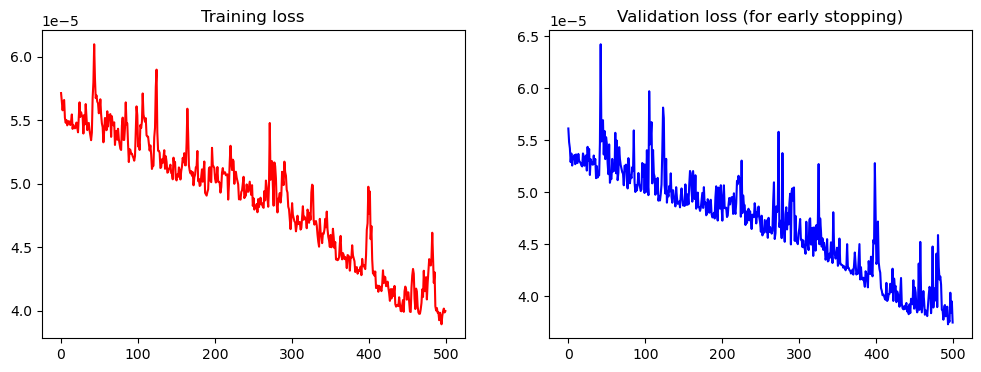

In [9]:
fig, (ax1, ax2) = plt.subplots(figsize=(12,4),ncols=2)

ax1.plot(l_tr,"r-")
ax1.set_title("Training loss")
ax2.plot(l_va,"b-")
ax2.set_title("Validation loss (for early stopping)")
plt.show()

Once fitted, we can check the estimation error of the fitted model. Some useful functions are in the *`Other_functions`* module.

In [10]:
import Other_functions as Ofn

In [12]:
loc = np.loadtxt(os.path.join("Demo-data","True_locations.dat"),dtype="float32")
u = torch.from_numpy(loc[:,:d])
v = torch.from_numpy(loc[:,d:])
del loc
cov_file = os.path.join("Demo-data","True_cov.dat")
err = Ofn.cnet_error_MC(model,u,v,cov_file)
print("Estimation error = {:.2f}%" .format(err*100))

Estimation error = 16.77%


Eigen-decomposition of the model can be obtained using the **PCA** function in *`CNet_PCA`* module.

In [13]:
import CNet_PCA as CPCA

In [14]:
u = np.loadtxt(os.path.join("Demo-data","True_locations_grid.dat"),dtype="float32")
    # grid points where the eigenfunctions are to be evaluated

eta, psi = CPCA.PCA(model,u,50000)

 - `CPCA.PCA(model,u,M,tol)` ---- Eigendecomposition of a CovNet model (Monte-Carlo version)
 
**Parameters:**
> * model ---- a CovNet model.
> * u ---- locations where the eigenfunctions are to be evaluated.
> * M ---- number of Monte-Carlo samples to compute the integrals (optional, default: 50000).
> * tol ---- a threshold for the eigenvalues. Eigenvalues < tol will be discarded (optional, default: 1e-10).

**Returns:**
> * eta ---- an array containing the eigenvalues.
> * psi ---- a matrix whose columns are the eigenfunctions evaluated at the locations specified by **u**.

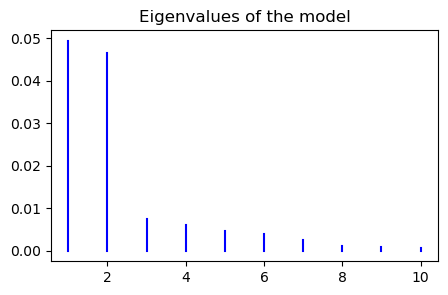

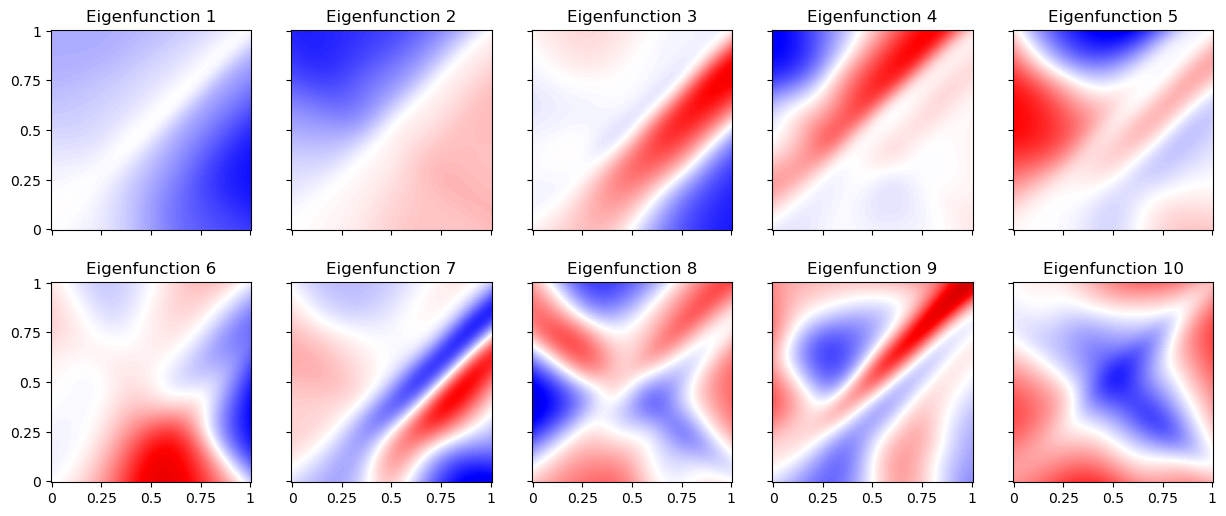

In [15]:
fig, ax = plt.subplots(figsize=(5,3),ncols=1)
for i in range(10):
    ax.plot([i+1,i+1],[0,eta[-(i+1)]],"b-")
ax.set_title("Eigenvalues of the model")
ax.set_xticks([2,4,6,8,10])
plt.show()

fig, axes = plt.subplots(figsize=(15,6),nrows=2,ncols=5,sharex=True,sharey=True)
vmax = np.max(np.abs(psi))
for i in range(10):
    ax = axes.flatten()[i]
    ax.imshow(psi[:,-(i+1)].reshape(100,100), origin="lower", cmap="seismic", vmin=-vmax,vmax=vmax)
    ax.set_xticks(np.linspace(0,99,5))
    ax.set_xticklabels([])
    ax.set_yticks(np.linspace(0,99,5))
    ax.set_yticklabels([0,0.25,0.5,0.75,1])
    ax.set_xticklabels([0,0.25,0.5,0.75,1])
    ax.set_title("Eigenfunction {}" .format(i+1))
plt.show()

For **CPCA.PCA** , integrals involved in the eigendecomposition are computed using Monte-Carlo. There is another version where the integrals are approximated using complete evaluation on dense grids. The relevant function is **CPCA.PCA_grids**

 - `CPCA.PCA_grid(model,u,res,tol)` ---- Eigendecomposition of a CovNet model (evaluation on dense grid version)
 
**Parameters:**
> * model ---- a CovNet model.
> * u ---- locations where the eigenfunctions are to be evaluated.
> * res ---- resolution (grid points per dimension) to compute the integrals (optional, default: 100).
> * tol ---- a threshold for the eigenvalues. Eigenvalues < tol will be discarded (optional, default: 1e-10).

**Returns:**
> * eta ---- an array containing the eigenvalues.
> * psi ---- a matrix whose columns are the eigenfunctions evaluated at the locations specified by **u**.

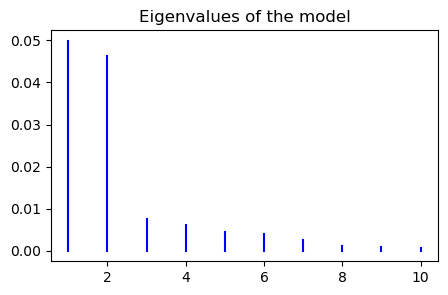

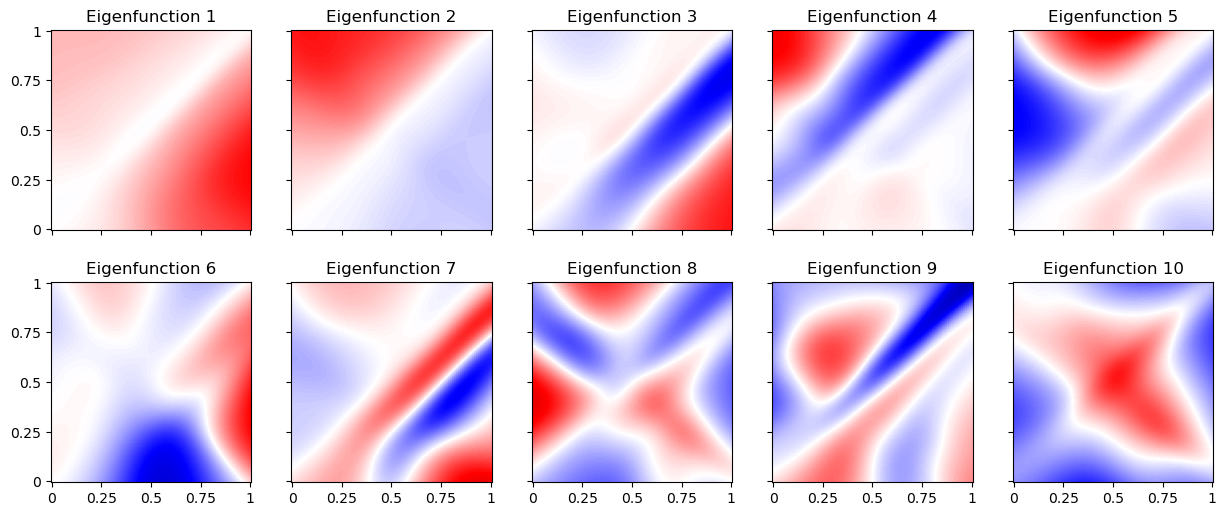

In [16]:
eta, psi = CPCA.PCA_grid(model,u,res=500)

fig, ax = plt.subplots(figsize=(5,3),ncols=1)
for i in range(10):
    ax.plot([i+1,i+1],[0,eta[-(i+1)]],"b-")
ax.set_title("Eigenvalues of the model")
ax.set_xticks([2,4,6,8,10])
plt.show()

fig, axes = plt.subplots(figsize=(15,6),nrows=2,ncols=5,sharex=True,sharey=True)
vmax = np.max(np.abs(psi))
for i in range(10):
    ax = axes.flatten()[i]
    ax.imshow(psi[:,-(i+1)].reshape(100,100), origin="lower", cmap="seismic", vmin=-vmax,vmax=vmax)
    ax.set_xticks(np.linspace(0,99,5))
    ax.set_xticklabels([])
    ax.set_yticks(np.linspace(0,99,5))
    ax.set_yticklabels([0,0.25,0.5,0.75,1])
    ax.set_xticklabels([0,0.25,0.5,0.75,1])
    ax.set_title("Eigenfunction {}" .format(i+1))
plt.show()

A CovNet model can be easily saved and restored using **torch.save** and **torch.load** functions in pytorch (see __https://pytorch.org/tutorials/beginner/saving_loading_models.html__).

**Usage:**
> * `torch.save(model.state_dict(), checkpoint)` ---- saves the current parameters of *model* to the file *checkpoint* (with extension .pt).
> * `model.load_state_dict(torch.load(checkpoint))` ---- loads parameters from the file *checkpoint* and assigns them to the *model* <br>
 **Note:** For loading the parameters, the size of the *model* (N,d,depth,R etc.) should match exactly with the one in *checkpoint*. Otherwise, an error will be raised.

In [17]:
torch.save(model.state_dict(),"checkpoint.pt")
    # saving the current parameters to "checkpoint.pt"

In [18]:
model.load_state_dict(torch.load("checkpoint.pt"))
    # restoring the saved parameters

<All keys matched successfully>

Finally, the mean estimation technique discussed in the paper can be implemented using **CPCA.mean** function.

 - `CPCA.mean(model,u)` ---- gives an estimate of the mean field

**Parameters:**
> * model ---- a CovNet model.
> * u ---- locations where the mean is to be evaluated.

**Returns:**
> * mu ---- an array whose elements are the mean evaluated at locations specified by **u**

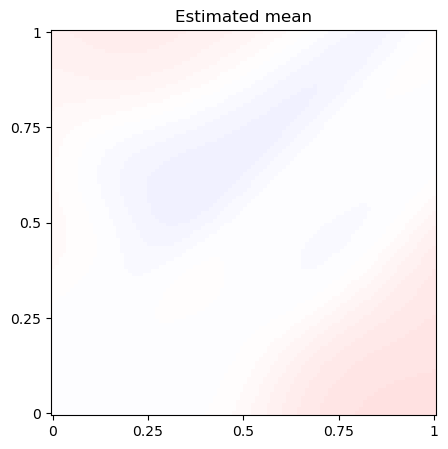

In [19]:
mu = CPCA.mean(model,u)

fig, ax = plt.subplots(figsize=(5,5),ncols=1)
ax.imshow(mu.reshape(100,100), origin="lower", cmap="seismic", vmin=-1,vmax=1)
ax.set_xticks(np.linspace(0,99,5))
ax.set_xticklabels([])
ax.set_yticks(np.linspace(0,99,5))
ax.set_yticklabels([0,0.25,0.5,0.75,1])
ax.set_xticklabels([0,0.25,0.5,0.75,1])
ax.set_title("Estimated mean")
plt.show()